# July 1, 2022: Compute Intersubject Correlation (ISC) values for threat and safe conditions

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import norm, zscore

# ISC
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc, 
                        timeshift_isc, phaseshift_isc, compute_summary_statistic)

from statsmodels.stats.multitest import multipletests

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils

In [2]:
'''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

num_rois = 85
args.roi_idxs = np.arange(num_rois)

with open(f"{proj_dir}/data/max/exploratory_data.pkl", 'rb') as f:
    X = pickle.load(f)

In [3]:
'''
find minimum number of trials across subjects
'''
min_trials = []
for label in args.LABELS:
    min_trials += [x.shape[0] for x in X[label]]
min_trials = min(min_trials)

ts = {}
for label, name in zip(args.LABELS, args.NAMES):
    ts[name] = []
    for x in X[label]:
        trl, t, r = x.shape
        x = np.reshape(x[:min_trials, ...], (min_trials*t, r))
        ts[name].append(zscore(x, axis=0))

## statistical tests

### bootsrap

number of significant rois for condition safe = 0
number of significant rois for condition threat = 36


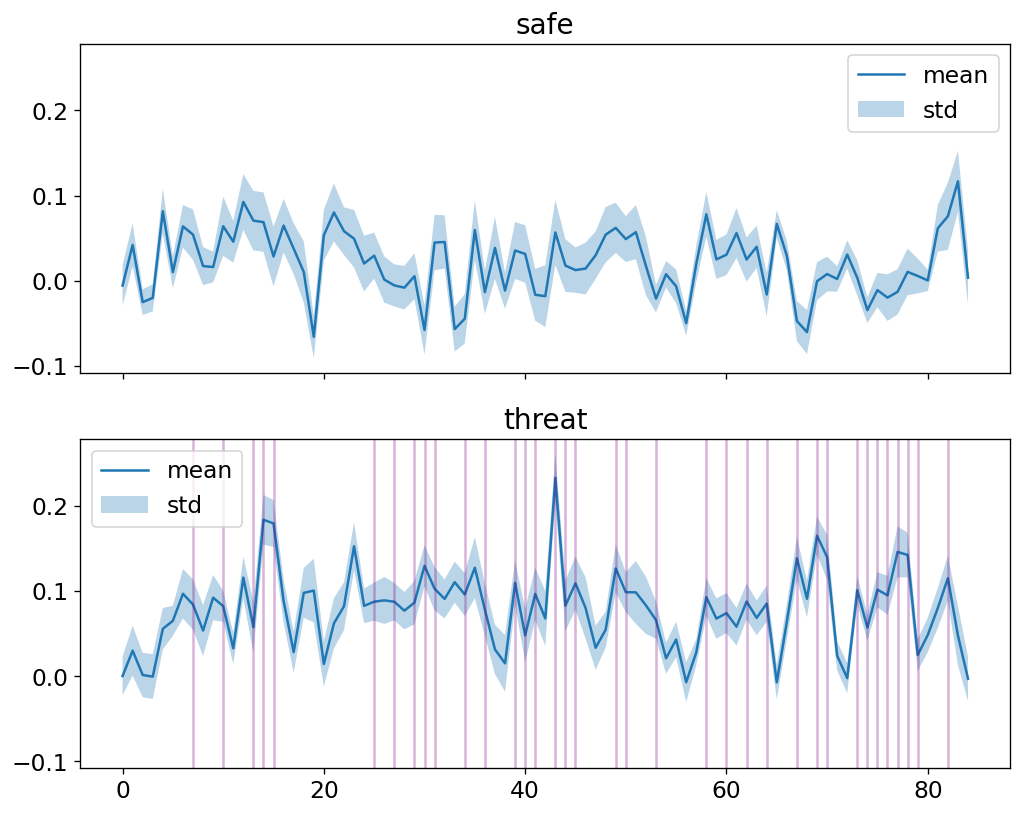

In [4]:
'''
ISC
pairwise
bootstrap
'''
args.pairwise = False
args.n_bootstraps = 1000
iscs = {}
bootstraps = {}
q = {}
z = {}
rois = {}
for label, name in zip(args.LABELS, args.NAMES):
    iscs[name] = isc(ts[name], pairwise=args.pairwise, summary_statistic=None)

    # permutation test
    bootstraps[name] = bootstrap_isc(
        iscs[name], pairwise=args.pairwise, 
        ci_percentile=95, 
        summary_statistic='median',
        n_bootstraps=args.n_bootstraps
    )

    # multiple tests correction
    q[name] = multipletests(bootstraps[name][2], method='fdr_by')[1]
    z[name] = np.abs(norm.ppf(q[name]))

    # surviving rois
    rois[name] = q[name][np.newaxis, :] < 0.05
    # rois[name] = bootstraps[name][2][np.newaxis, :] < 0.05
    print(f"number of significant rois for condition {name} = {np.sum(rois[name])}")


nrows, ncols = len(args.LABELS), 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(10*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)

for label, name in zip(args.LABELS, args.NAMES):
    ax = axs[label]
    ax.set_title(f"{name}")

    # ax.plot(np.min(iscs[name], axis=0), label='min')
    # ax.plot(np.max(iscs[name], axis=0), label='max')

    mn = np.mean(iscs[name], axis=0)
    st = np.std(iscs[name], axis=0) / np.sqrt(len(ts[name]))
    ax.plot(mn, label='mean')
    ax.fill_between(
        np.arange(st.shape[0]),
        (mn - st), (mn + st),
        label='std',
        alpha=0.3
    )

    for r in np.where(rois[name])[1]:
        ax.axvline(r, color='purple', alpha=0.3)
    
    ax.legend()

### permutation

number of significant rois for condition safe = 0
number of significant rois for condition threat = 35


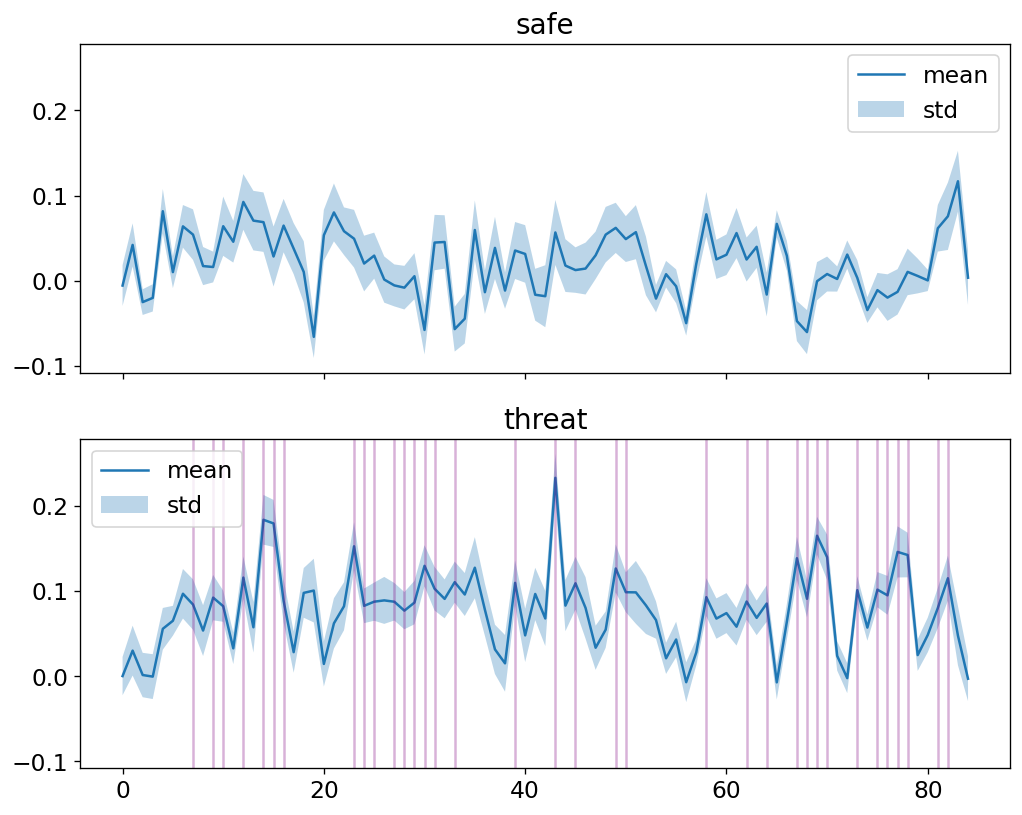

In [5]:
'''
ISC
pairwise
permutation
'''
args.pairwise = False
args.n_permutations = 1000
iscs = {}
bootstraps = {}
q = {}
z = {}
rois = {}
for label, name in zip(args.LABELS, args.NAMES):
    iscs[name] = isc(ts[name], pairwise=args.pairwise, summary_statistic=None)

    # permutation test
    bootstraps[name] = permutation_isc(
        iscs[name], pairwise=args.pairwise, 
        summary_statistic='median',
        n_permutations=args.n_permutations
    )

    # multiple tests correction
    q[name] = multipletests(bootstraps[name][1], method='fdr_by')[1]
    z[name] = np.abs(norm.ppf(q[name]))

    # surviving rois
    rois[name] = q[name][np.newaxis, :] < 0.05
    # rois[name] = bootstraps[name][1][np.newaxis, :] < 0.05
    print(f"number of significant rois for condition {name} = {np.sum(rois[name])}")

    
nrows, ncols = len(args.LABELS), 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(10*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)

for label, name in zip(args.LABELS, args.NAMES):
    ax = axs[label]
    ax.set_title(f"{name}")

    # ax.plot(np.min(iscs[name], axis=0), label='min')
    # ax.plot(np.max(iscs[name], axis=0), label='max')

    mn = np.mean(iscs[name], axis=0)
    st = np.std(iscs[name], axis=0) / np.sqrt(len(ts[name]))
    ax.plot(mn, label='mean')
    ax.fill_between(
        np.arange(st.shape[0]),
        (mn - st), (mn + st),
        label='std',
        alpha=0.3
    )

    for r in np.where(rois[name])[1]:
        ax.axvline(r, color='purple', alpha=0.3)
    
    ax.legend()

### circular time-shift

number of significant rois for condition safe = 0
number of significant rois for condition threat = 35


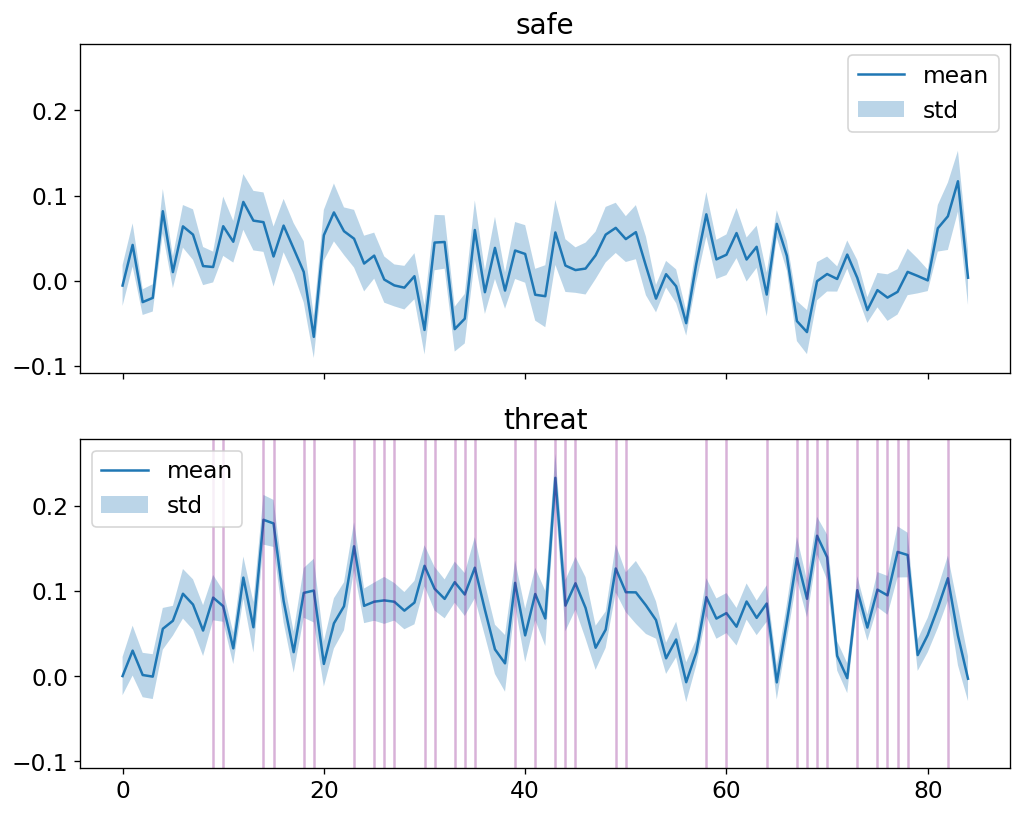

In [6]:
'''
ISC
pairwise
circular time-shift
'''
args.pairwise = False
args.n_shifts = 1000
iscs = {}
bootstraps = {}
q = {}
z = {}
rois = {}
for label, name in zip(args.LABELS, args.NAMES):
    iscs[name] = isc(ts[name], pairwise=args.pairwise, summary_statistic=None)

    # permutation test
    bootstraps[name] = timeshift_isc(
        ts[name], pairwise=args.pairwise,
        summary_statistic='median',
        n_shifts=args.n_shifts)

    # multiple tests correction
    q[name] = multipletests(bootstraps[name][1], method='fdr_by')[1]
    z[name] = np.abs(norm.ppf(q[name]))

    # surviving rois
    rois[name] = q[name][np.newaxis, :] < 0.05
    # rois[name] = bootstraps[name][1][np.newaxis, :] < 0.05
    print(f"number of significant rois for condition {name} = {np.sum(rois[name])}")

    
nrows, ncols = len(args.LABELS), 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(10*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)

for label, name in zip(args.LABELS, args.NAMES):
    ax = axs[label]
    ax.set_title(f"{name}")

    # ax.plot(np.min(iscs[name], axis=0), label='min')
    # ax.plot(np.max(iscs[name], axis=0), label='max')

    mn = np.mean(iscs[name], axis=0)
    st = np.std(iscs[name], axis=0) / np.sqrt(len(ts[name]))
    ax.plot(mn, label='mean')
    ax.fill_between(
        np.arange(st.shape[0]),
        (mn - st), (mn + st),
        label='std',
        alpha=0.3
    )

    for r in np.where(rois[name])[1]:
        ax.axvline(r, color='purple', alpha=0.3)
    
    ax.legend()

### phase randomization

number of significant rois for condition safe = 0
number of significant rois for condition threat = 36


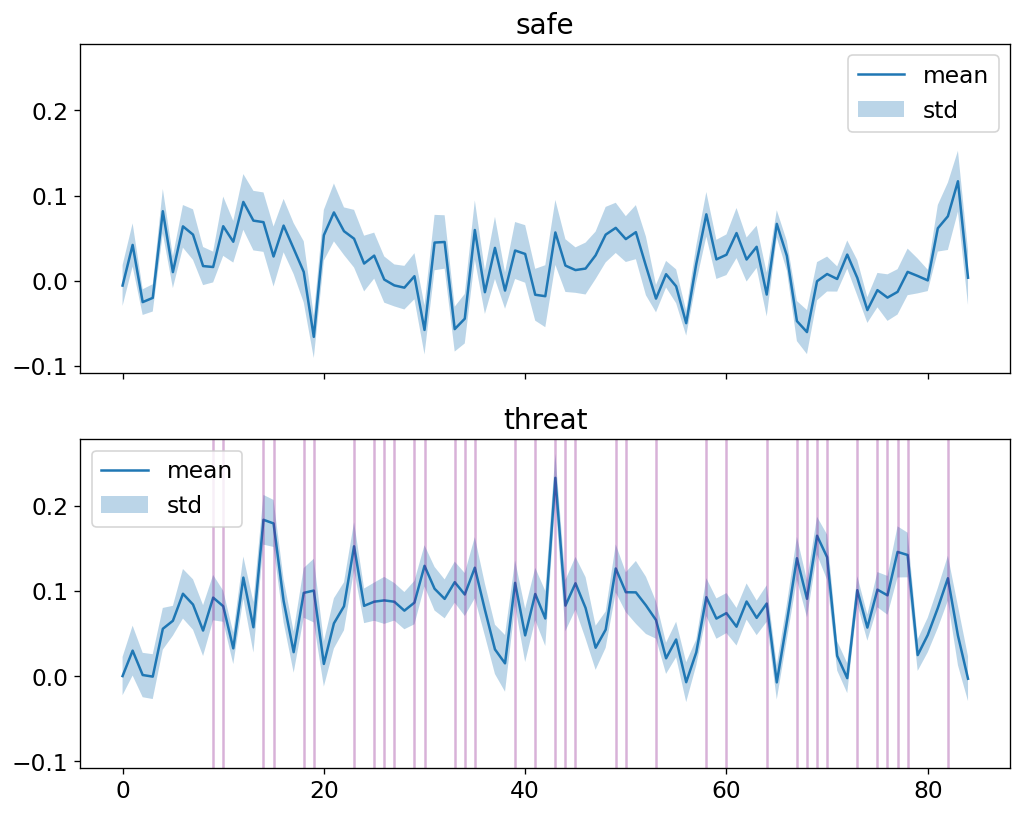

In [7]:
'''
ISC
pairwise
phase randomization
'''
args.pairwise = False
args.n_shifts = 1000
iscs = {}
bootstraps = {}
q = {}
z = {}
rois = {}
for label, name in zip(args.LABELS, args.NAMES):
    iscs[name] = isc(ts[name], pairwise=args.pairwise, summary_statistic=None)

    # permutation test
    bootstraps[name] = phaseshift_isc(
        ts[name], pairwise=args.pairwise,
        summary_statistic='median',
        n_shifts=args.n_shifts)

    # multiple tests correction
    q[name] = multipletests(bootstraps[name][1], method='fdr_by')[1]
    z[name] = np.abs(norm.ppf(q[name]))

    # surviving rois
    rois[name] = q[name][np.newaxis, :] < 0.05
    # rois[name] = bootstraps[name][1][np.newaxis, :] < 0.05
    print(f"number of significant rois for condition {name} = {np.sum(rois[name])}")

    
nrows, ncols = len(args.LABELS), 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(10*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)

for label, name in zip(args.LABELS, args.NAMES):
    ax = axs[label]
    ax.set_title(f"{name}")

    # ax.plot(np.min(iscs[name], axis=0), label='min')
    # ax.plot(np.max(iscs[name], axis=0), label='max')

    mn = np.mean(iscs[name], axis=0)
    st = np.std(iscs[name], axis=0) / np.sqrt(len(ts[name]))
    ax.plot(mn, label='mean')
    ax.fill_between(
        np.arange(st.shape[0]),
        (mn - st), (mn + st),
        label='std',
        alpha=0.3
    )

    for r in np.where(rois[name])[1]:
        ax.axvline(r, color='purple', alpha=0.3)
    
    ax.legend()

## Following the pipeline in ISC tutorial
Paper: https://academic.oup.com/scan/article/14/6/667/5489905
Tutorial: https://github.com/snastase/isc-tutorial

Statistical significance was assessed by a nonparametric bootstrap hypothesis test resampling left-out subjects and corrected for multiple tests by controlling FDR at .05.

i.e.:
1. Compute leave-one-out (LOO) ISC values
2. Bootstrap hypothesis testing, (Chen et al.2016)
3. Multiple tests correction: False Discovery Rate (FDR) at 0.05.

LOO method relates to computing ISFC values, as the mean time series of the remaining subjects converges to the common signal across subjects.